# ES(1+1) with 1/5 Rule

Name: Batyr Kenzheakhmetov

In [ ]:
# import libraries
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

# load the dataset
file_path = '/content/gdrive/My Drive/AirQualityData/AirQualityUCI.csv'
data = pd.read_csv(file_path, delimiter=';')

# clean numeric columns
columns_to_clean = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # origianl article did not include CO(GT)

# replace commas with dots and convert them to numeric
for col in columns_to_clean:
    data[col] = data[col].str.replace(',', '.')
    data[col] = pd.to_numeric(data[col], errors='coerce')

# drop the unnamed columns and any rows with missing values
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16']).dropna()

# convert 'Date' and 'Time' to a single DateTime index <=== Not a colum!!!
data_cleaned['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
data_cleaned = data_cleaned.set_index('DateTime')

# drop the 'Date' and 'Time' columns
data_cleaned = data_cleaned.drop(columns=['Date', 'Time'])

# ensure all columns are numeric
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

# drop rows with NaN
data_cleaned = data_cleaned.dropna()

# split the data (80% train, 20% test)
train_size = int(len(data_cleaned) * 0.8)
train_data = data_cleaned[:train_size]
test_data = data_cleaned[train_size:]


# printing first ten rows
print(train_data.head(10))
print(train_data.shape)

Mounted at /content/gdrive
                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
2004-03-10 23:00:00     1.2       1197.0      38.0       4.7          750.0   
2004-03-11 00:00:00     1.2       1185.0      31.0       3.6          690.0   
2004-03-11 01:00:00     1.0       1136.0      31.0       3.3          672.0   
2004-03-11 02:00:00     0.9       1094.0      24.0       2.3          609.0   
2004-03-11 03:00:00     0.6       1010.0      19.0       1.7          561.0   

                     NOx

In [ ]:
# data preparation
n_lags = 3

def create_lagged_features_lstm(data, n_lags):
    lagged_data = data.copy()
    for i in range(1, n_lags + 1):
        lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
    lagged_data = lagged_data.dropna() # drop any rows with missing values
    return lagged_data

# apply lagged feature generation to train_data and test_data
train_data_lagged = create_lagged_features_lstm(train_data, n_lags)
test_data_lagged = create_lagged_features_lstm(test_data, n_lags)

print(train_data_lagged.iloc[0])
print(train_data_lagged.shape)
# print(test_data_lagged.head())
print(test_data_lagged.shape)

CO(GT)              2.2000
PT08.S1(CO)      1376.0000
NMHC(GT)           80.0000
C6H6(GT)            9.2000
PT08.S2(NMHC)     948.0000
NOx(GT)           172.0000
PT08.S3(NOx)     1092.0000
NO2(GT)           122.0000
PT08.S4(NO2)     1584.0000
PT08.S5(O3)      1203.0000
T                  11.0000
RH                 60.0000
AH                  0.7867
NOx_lag_1         131.0000
NOx_lag_2         103.0000
NOx_lag_3         166.0000
Name: 2004-03-10 21:00:00, dtype: float64
(7482, 16)
(1869, 16)


In [ ]:
# separate X and y
X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values  # Use all features
y_train = train_data_lagged['NOx(GT)'].values
print(X_train_all_features.shape)
print(y_train.shape)
print(y_train[0:5])
print(y_train[-5:])

X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
y_test = test_data_lagged['NOx(GT)'].values

# reshape data for LSTM (samples, timesteps, features)
# //  <--- floor division
X_train_lstm_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
X_test_lstm_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))

print(X_train_lstm_all_features.shape)
print(X_test_lstm_all_features.shape)
print(X_train_lstm_all_features[0:2])
print(X_train_lstm_all_features[-2:])

(7482, 15)
(7482,)
[172. 131.  89.  62.  62.]
[172. 138. 121. 143. 114.]
(7482, 3, 5)
(1869, 3, 5)
[[[2.200e+00 1.376e+03 8.000e+01 9.200e+00 9.480e+02]
  [1.092e+03 1.220e+02 1.584e+03 1.203e+03 1.100e+01]
  [6.000e+01 7.867e-01 1.310e+02 1.030e+02 1.660e+02]]

 [[1.600e+00 1.272e+03 5.100e+01 6.500e+00 8.360e+02]
  [1.205e+03 1.160e+02 1.490e+03 1.110e+03 1.120e+01]
  [5.960e+01 7.888e-01 1.720e+02 1.310e+02 1.030e+02]]]
[[[ 1.000e+00  8.660e+02 -2.000e+02  3.000e+00  6.520e+02]
  [ 1.060e+03  9.800e+01  8.570e+02  5.730e+02  1.190e+01]
  [ 3.080e+01  4.285e-01  1.210e+02  1.380e+02  1.720e+02]]

 [[ 8.000e-01  8.190e+02 -2.000e+02  1.900e+00  5.760e+02]
  [ 1.142e+03  8.500e+01  8.090e+02  4.920e+02  1.140e+01]
  [ 3.200e+01  4.310e-01  1.430e+02  1.210e+02  1.380e+02]]]


In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Input
from keras.callbacks import EarlyStopping
from keras import optimizers


act_func = ('relu', 'elu')
optimz = ('RMSprop', 'Adam')
lags = (2, 3, 4, 6)

def LSTM_Function(param):
    # data preparation
    n_lags = lags[int(param[5])]

    def create_lagged_features_lstm(data, n_lags):
        lagged_data = data.copy()
        for i in range(1, n_lags + 1):
            lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
        lagged_data = lagged_data.dropna() # drop any rows with missing values
        return lagged_data


    # apply lagged feature generation to train_data and test_data
    train_data_lagged = create_lagged_features_lstm(train_data, n_lags)
    test_data_lagged = create_lagged_features_lstm(test_data, n_lags)


    # separate X and y
    X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values  # Use all features
    y_train = train_data_lagged['NOx(GT)'].values
    X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
    y_test = test_data_lagged['NOx(GT)'].values


    # reshape data for LSTM (samples, timesteps, features)
    # //  <--- floor division
    X_train_lstm_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
    X_test_lstm_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))



    # Build the model
    model_all_features = Sequential()
    model_all_features.add(Input(shape=(n_lags, X_train_lstm_all_features.shape[2])))
    model_all_features.add(LSTM(int(param[0]), activation=act_func[int(param[3])]))
    model_all_features.add(Dense(1))

    # Optimizer selection
    if param[4] == 0:
        optmzr = optimizers.RMSprop(learning_rate=param[1])
    elif param[4] == 1:
        optmzr = optimizers.Adam(learning_rate=param[1])

    model_all_features.compile(optimizer=optmzr, loss='mse')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history_all_features = model_all_features.fit(
        X_train_lstm_all_features, y_train,
        epochs=50, batch_size=int(param[2]),
        validation_data=(X_test_lstm_all_features, y_test),
        callbacks=[early_stopping], verbose=0
    )

    # Predict
    y_pred_all_features = model_all_features.predict(X_test_lstm_all_features)

    # Flatten predictions
    y_pred_all_features = y_pred_all_features.flatten()

    # Skip trials with NaN predictions
    if np.any(np.isnan(y_pred_all_features)):
        return float('inf')  # High loss for invalid trials

    # Evaluate
    rmse_all_features = np.sqrt(mean_squared_error(y_test, y_pred_all_features))

    return rmse_all_features



# 50 LSTM units, 0.001 learning rate, batch size 32, 'relu' activation (index 0), 'Adam' optimizer (index 1), 3 number of lags (index 1)
params = [50, 0.001, 32, 0, 1, 1]  # Example parameters:

rmse = LSTM_Function(params)
print(f"RMSE: {rmse}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 71.59649357926101


In [ ]:
# Constants
MaxGen = 1000
MaxTrial = 5
numVar = 6

# acceptable range for each hyper parameter
low0 = 250  # number of hidden neurons
high0 = 350
low1  = 0.001 # smallest learning rate
high1 = 0.1
low2  = 8 # min batch size
high2 = 32

totgen = 0
foundCnt = 0  # acceptable solution found
objfunc = LSTM_Function

# for 1/5 rule
stepSize_i = 0.82 # initial stepsize
stepSize_r = 0.82 # stepsize change ratio.
                  # 0.82 was used previously by Hans-Paul Schwefel, a PhD student of Rechenberg


print(f"[#neurons, #lags, lr, bsize, actfun, optmzr]")

def print_HP_found(x, eval):
  print(f"#neurons={int(x[0])}, #lags={lags[int(x[5])]}, lr={x[1]:.5f}, bsize={int(x[2])}, actF={act_func[int(x[3])]}, optim={optimz[int(x[4])]}")
  print(f"RMSE={eval:.5f}")

for trial in range(0, MaxTrial):
    xp = np.empty(numVar) # parent
    p_val = 0
    xo = np.empty(numVar) # offspring
    o_val = 0

    successCnt = 0;
    WindowSize = 10


    print(f"************************** Trial # = {trial+1}")

    # initialize hyper parameters
    xp[0] = np.random.randint(low0, high0)
    xp[1] = round(np.random.uniform(low1, high1), 5) # init learning rate
    xp[2] = 16 # batch size
    xp[3] = 0 # sigmoid
    xp[4] = 1 # optimizer
    xp[5] = 0 # lags

    p_val = objfunc(xp)     # evaluate the parent

    stepSize = stepSize_i

    for g in range(1, MaxGen+1):
        if (g % WindowSize) == 0: # update stepsize
            if successCnt > (WindowSize * 0.2):
                stepSize = stepSize / stepSize_r #increase
            elif successCnt < (WindowSize * 0.2):
                stepSize = stepSize * stepSize_r #decrease
            #else do not change stepSize
            #print(successCnt, stepSize)
            successCnt = 0

        def mutate_activation_function(xp, stepSize):
            current_act = int(xp[3])  # Current activation function index
            # Calculate the transition index based on step size (cyclical movement)
            new_act = (current_act + int(np.sign(np.random.normal(0, stepSize)))) % len(act_func)
            xp[3] = new_act
            return xp

        def mutate_optimizer(xp, stepSize):
            current_opt = int(xp[4])  # Current optimizer index
            # Calculate the transition index based on step size (cyclical movement)
            new_opt = (current_opt + int(np.sign(np.random.normal(0, stepSize)))) % len(optimz)
            xp[4] = new_opt
            return xp

        def mutate_lags_number(xp, stepSize):
            current_lags = int(xp[5])  # Current number of lags
            # Calculate the transition index based on step size (cyclical movement)
            new_lags = (current_lags + int(np.sign(np.random.normal(0, stepSize)))) % len(lags)
            xp[5] = new_lags
            return xp

        # Existing mutation for continuous parameters
        def mutate_continuous(x, index, low, high, stepSize):
            x[index] = int(x[index] + int(np.round(np.random.normal(0.0, stepSize))))
            if x[index] < low: x[index] = low
            elif x[index] > high: x[index] = high
            return x

        def mutate_learning_rate(x, index, low, high, stepSize):
            # Add random noise (normal distribution) to the parameter
            x[index] = x[index] + np.random.normal(0.0, stepSize)
            # Ensure the value stays within bounds
            if x[index] < low: x[index] = low
            elif x[index] > high: x[index] = high
            return x

        # def mutate_neurons(x, index, low, high, step_size):
        #     # Mutate with a larger step size for neurons
        #     x[index] = int(x[index] + int(np.round(np.random.normal(0.0, stepSize))))
        #     if x[index] < low:
        #         x[index] = low
        #     elif x[index] > high:
        #         x[index] = high
        #     return x

        # Example of integrating this into the main loop where we mutate each hyperparameter
        def mutate_hyperparameters(xp, stepSize):
            # Mutate number of hidden neurons
            xp = mutate_continuous(xp, 0, low0, high0, stepSize)

            # Mutate learning rate
            xp = mutate_learning_rate(xp, 1, low1, high1, stepSize)

            # Mutate batch size
            xp = mutate_continuous(xp, 2, low2, high2, stepSize)

            # Mutate activation function using the custom operator
            xp = mutate_activation_function(xp, stepSize)

            # Mutate optimizer using the custom operator
            xp = mutate_optimizer(xp, stepSize)

            # Mutate number of lags
            xp = mutate_lags_number(xp, stepSize)

            return xp

        # Mutate the hyperparameters using the new function
        xo = xp.copy()  # create offspring by copying the parent
        xo = mutate_hyperparameters(xo, stepSize)  # mutate the offspring

        o_val = objfunc(xo)  # evaluate offspring

        # select
        if o_val < p_val:
            #xp = xo # No! must maintain two separate spaces
            xp = xo.copy()
            p_val = o_val
            successCnt += 1;


        if p_val < 60: # we assume minima is zero.
            print(f"Acceptable solution found after {g} iterations:")
            #print(f"{xp}, {p_val:.5f}")
            print_HP_found(xp, p_val)
            totgen += g
            foundCnt += 1
            break # cannot use while since it may not find acceptable minia

print(f"System Success = {foundCnt/MaxTrial*100}%")
totgen += (MaxTrial-foundCnt)*MaxGen
print(f"Avgerage # of generations used = {(totgen/MaxTrial):,.0f}")

[#neurons, #lags, lr, bsize, actfun, optmzr]
************************** Trial # = 1
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Acceptable solution found after 10 iterations:
#neurons=332, #lags=4, lr=0.00100, bsize=15, actF=relu, optim=Adam
RMSE=53.79395
************************** Trial # = 2
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59

In [ ]:
from keras.layers import GRU


def GRU_Function(param):
    # data preparation
    n_lags = lags[int(param[5])]

    def create_lagged_features_lstm(data, n_lags):
        lagged_data = data.copy()
        for i in range(1, n_lags + 1):
            lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
        lagged_data = lagged_data.dropna() # drop any rows with missing values
        return lagged_data


    # apply lagged feature generation to train_data and test_data
    train_data_lagged = create_lagged_features_lstm(train_data, n_lags)
    test_data_lagged = create_lagged_features_lstm(test_data, n_lags)


    # separate X and y
    X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values  # Use all features
    y_train = train_data_lagged['NOx(GT)'].values
    X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
    y_test = test_data_lagged['NOx(GT)'].values


    # reshape data for LSTM (samples, timesteps, features)
    # //  <--- floor division
    X_train_lstm_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
    X_test_lstm_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))



    # Build the model
    model_all_features = Sequential()
    model_all_features.add(Input(shape=(n_lags, X_train_lstm_all_features.shape[2])))
    model_all_features.add(GRU(int(param[0]), activation=act_func[int(param[3])]))
    model_all_features.add(Dense(1))

    # Optimizer selection
    if param[4] == 0:
        optmzr = optimizers.RMSprop(learning_rate=param[1])
    elif param[4] == 1:
        optmzr = optimizers.Adam(learning_rate=param[1])

    model_all_features.compile(optimizer=optmzr, loss='mse')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history_all_features = model_all_features.fit(
        X_train_lstm_all_features, y_train,
        epochs=100, batch_size=int(param[2]),
        validation_data=(X_test_lstm_all_features, y_test),
        callbacks=[early_stopping], verbose=0
    )

    # Predict
    y_pred_all_features = model_all_features.predict(X_test_lstm_all_features)

    # Flatten predictions
    y_pred_all_features = y_pred_all_features.flatten()

    # Skip trials with NaN predictions
    if np.any(np.isnan(y_pred_all_features)):
        return float('inf')  # High loss for invalid trials

    # Evaluate
    rmse_all_features = np.sqrt(mean_squared_error(y_test, y_pred_all_features))

    return rmse_all_features

# Constants
MaxGen = 1000
MaxTrial = 5
numVar = 6

# acceptable range for each hyper parameter
low0 = 250  # number of hidden neurons
high0 = 350
low1  = 0.001 # smallest learning rate
high1 = 0.1
low2  = 8 # min batch size
high2 = 32

totgen = 0
foundCnt = 0  # acceptable solution found

# for 1/5 rule
stepSize_i = 0.82 # initial stepsize
stepSize_r = 0.82 # stepsize change ratio.
                  # 0.82 was used previously by Hans-Paul Schwefel, a PhD student of Rechenberg


print(f"[#neurons, #lags, lr, bsize, actfun, optmzr]")

def print_HP_found(x, eval):
  print(f"#neurons={int(x[0])}, #lags={lags[int(x[5])]}, lr={x[1]:.5f}, bsize={int(x[2])}, actF={act_func[int(x[3])]}, optim={optimz[int(x[4])]}")
  print(f"RMSE={eval:.5f}")

objfunc = GRU_Function

for trial in range(0, MaxTrial):
    xp = np.empty(numVar) # parent
    p_val = 0
    xo = np.empty(numVar) # offspring
    o_val = 0

    successCnt = 0;
    WindowSize = 10


    print(f"************************** Trial # = {trial+1}")

    # initialize hyper parameters
    xp[0] = np.random.randint(low0, high0)
    xp[1] = round(np.random.uniform(low1, high1), 5) # init learning rate
    xp[2] = 1 # batch size
    xp[3] = 0 # sigmoid
    xp[4] = 1 # optimizer
    xp[5] = 0 # lags

    p_val = objfunc(xp)     # evaluate the parent

    stepSize = stepSize_i

    for g in range(1, MaxGen+1):
        if (g % WindowSize) == 0: # update stepsize
            if successCnt > (WindowSize * 0.2):
                stepSize = stepSize / stepSize_r #increase
            elif successCnt < (WindowSize * 0.2):
                stepSize = stepSize * stepSize_r #decrease
            #else do not change stepSize
            #print(successCnt, stepSize)
            successCnt = 0

        def mutate_activation_function(xp, stepSize):
            current_act = int(xp[3])  # Current activation function index
            # Calculate the transition index based on step size (cyclical movement)
            new_act = (current_act + int(np.sign(np.random.normal(0, stepSize)))) % len(act_func)
            xp[3] = new_act
            return xp

        def mutate_optimizer(xp, stepSize):
            current_opt = int(xp[4])  # Current optimizer index
            # Calculate the transition index based on step size (cyclical movement)
            new_opt = (current_opt + int(np.sign(np.random.normal(0, stepSize)))) % len(optimz)
            xp[4] = new_opt
            return xp

        def mutate_lags_number(xp, stepSize):
            current_lags = int(xp[5])  # Current number of lags
            # Calculate the transition index based on step size (cyclical movement)
            new_lags = (current_lags + int(np.sign(np.random.normal(0, stepSize)))) % len(lags)
            xp[5] = new_lags
            return xp

        # Existing mutation for continuous parameters
        def mutate_continuous(x, index, low, high, stepSize):
            x[index] = int(x[index] + int(np.round(np.random.normal(0.0, stepSize))))
            if x[index] < low: x[index] = low
            elif x[index] > high: x[index] = high
            return x

        def mutate_learning_rate(x, index, low, high, stepSize):
            # Add random noise (normal distribution) to the parameter
            x[index] = x[index] + np.random.normal(0.0, stepSize)
            # Ensure the value stays within bounds
            if x[index] < low: x[index] = low
            elif x[index] > high: x[index] = high
            return x

        # def mutate_neurons(x, index, low, high, step_size):
        #     # Mutate with a larger step size for neurons
        #     x[index] = int(x[index] + int(np.round(np.random.normal(0.0, stepSize))))
        #     if x[index] < low:
        #         x[index] = low
        #     elif x[index] > high:
        #         x[index] = high
        #     return x

        # Example of integrating this into the main loop where we mutate each hyperparameter
        def mutate_hyperparameters(xp, stepSize):
            # Mutate number of hidden neurons
            xp = mutate_continuous(xp, 0, low0, high0, stepSize)

            # Mutate learning rate
            xp = mutate_learning_rate(xp, 1, low1, high1, stepSize)

            # Mutate batch size
            xp = mutate_continuous(xp, 2, low2, high2, stepSize)

            # Mutate activation function using the custom operator
            xp = mutate_activation_function(xp, stepSize)

            # Mutate optimizer using the custom operator
            xp = mutate_optimizer(xp, stepSize)

            # Mutate number of lags
            xp = mutate_lags_number(xp, stepSize)

            return xp

        # Mutate the hyperparameters using the new function
        xo = xp.copy()  # create offspring by copying the parent
        xo = mutate_hyperparameters(xo, stepSize)  # mutate the offspring

        o_val = objfunc(xo)  # evaluate offspring

        # select
        if o_val < p_val:
            #xp = xo # No! must maintain two separate spaces
            xp = xo.copy()
            p_val = o_val
            successCnt += 1;


        if p_val < 60: # we assume minima is zero.
            print(f"Acceptable solution found after {g} iterations:")
            #print(f"{xp}, {p_val:.5f}")
            print_HP_found(xp, p_val)
            totgen += g
            foundCnt += 1
            break # cannot use while since it may not find acceptable minia

print(f"System Success = {foundCnt/MaxTrial*100}%")
totgen += (MaxTrial-foundCnt)*MaxGen
print(f"Avgerage # of generations used = {(totgen/MaxTrial):,.0f}")

[#neurons, #lags, lr, bsize, actfun, optmzr]
************************** Trial # = 1
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Acceptable solution found after 11 iterations:
#neurons=301, #lags=3, lr=0.00100, bsize=8, actF=elu, optim=RMSprop
RMSE=57.95436
************************** Trial # = 2
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms

In [ ]:
import pandas as pd

# Updated Data based on Trial Results
data = {
    "Trial #": [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    "System": ["LSTM", "LSTM", "LSTM", "LSTM", "LSTM", "GRU", "GRU", "GRU", "GRU", "GRU"],
    "# neurons": [332, 281, 250, 300, 321, 283, 287, 250, 328, 286],
    "# lags": [4, 3, 2, 3, 2, 3, 6, 3, 3, 3],
    "Learning rate": [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
    "Batch size": [15, 15, 17, 15, 15, 10, 8, 11, 8, 8],
    "Activation function": ["relu", "elu", "relu", "elu", "relu", "elu", "elu", "elu", "elu", "elu"],
    "Optimizer": ["Adam", "RMSprop", "Adam", "RMSprop", "Adam", "RMSprop", "RMSprop", "RMSprop", "RMSprop", "RMSprop"],
    "Loss": [
        53.79395, 58.37963, 59.57211, 57.35670, 56.73787,
        59.09231, 59.30344, 56.83308, 58.47610, 59.76044
    ],
    "Iterations": [10, 12, 6, 16, 4, 7, 2, 7, 2, 4],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Style and display the DataFrame
styled_df = df.style.set_properties(
    **{'background-color': '#b3d9ff', 'color': 'black', 'border-color': 'black'}
)
styled_df


,Trial #,System,# neurons,# lags,Learning rate,Batch size,Activation function,Optimizer,Loss,Iterations
0,1,LSTM,332,4,0.001000,15,relu,Adam,53.793950,10
1,2,LSTM,281,3,0.001000,15,elu,RMSprop,58.379630,12
2,3,LSTM,250,2,0.001000,17,relu,Adam,59.572110,6
3,4,LSTM,300,3,0.001000,15,elu,RMSprop,57.356700,16
4,5,LSTM,321,2,0.001000,15,relu,Adam,56.737870,4
5,1,GRU,283,3,0.001000,10,elu,RMSprop,59.092310,7
6,2,GRU,287,6,0.001000,8,elu,RMSprop,59.303440,2
7,3,GRU,250,3,0.001000,11,elu,RMSprop,56.833080,7
8,4,GRU,328,3,0.001000,8,elu,RMSprop,58.476100,2
9,5,GRU,286,3,0.001000,8,elu,RMSprop,59.760440,4


# DEAP Framework

Name: Batyr Kenzheakhmetov

The provided code implements a pipeline to forecast air quality metrics using LSTM models. It encompasses data preprocessing, feature engineering, and hyperparameter optimization through DEAP's evolutionary algorithm. This report evaluates the code, identifies its strengths, and suggests improvements for enhanced efficiency and scalability.



In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.6 MB/s eta 0:00:00


In [13]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
from google.colab import drive, files
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Clean up any pre-existing DEAP classes
if "FitnessMin" in creator.__dict__:
    del creator.FitnessMin
if "Individual" in creator.__dict__:
    del creator.Individual

from google.colab import drive, files
import pandas as pd

# Mount Google Drive
drive.mount('/content/gdrive')

# Specify file path
file_path = '/content/gdrive/My Drive/DL_data/airQualityUCI/AirQualityUCI.xlsx'

# Verify if file exists; if not, upload manually
import os
if not os.path.exists(file_path):
    print("File not found. Please upload the file.")
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

# Load the dataset from Excel
try:
    data = pd.read_excel(file_path)
    print("File loaded successfully!")
except Exception as e:
    print(f"Error loading file: {e}")
    raise e

# Clean numeric columns
columns_to_clean = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_clean:
    if col in data.columns and data[col].dtype == 'object':  # Apply replacement only to string columns
        data[col] = data[col].str.replace(',', '.')
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop unnecessary columns
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16'], errors='ignore').dropna()

# Add DateTime index
if 'Date' in data.columns and 'Time' in data.columns:
    # Ensure 'Date' and 'Time' are strings before concatenation
    data['Date'] = data['Date'].astype(str)
    data['Time'] = data['Time'].astype(str)
    data_cleaned['DateTime'] = pd.to_datetime(
        data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce'
    )
    data_cleaned = data_cleaned.set_index('DateTime').drop(columns=['Date', 'Time'], errors='ignore')
else:
    print("Error: 'Date' or 'Time' column is missing in the dataset.")

# Drop any rows with NaN
data_cleaned = data_cleaned.dropna()

print("Data successfully loaded and cleaned!")


# Train-test split
train_size = int(len(data_cleaned) * 0.8)
train_data = data_cleaned[:train_size]
test_data = data_cleaned[train_size:]

# Create lagged features
n_lags = 3

def create_lagged_features_lstm(data, n_lags):
    lagged_data = data.copy()
    for i in range(1, n_lags + 1):
        lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
    lagged_data = lagged_data.dropna()
    return lagged_data

train_data_lagged = create_lagged_features_lstm(train_data, n_lags)
test_data_lagged = create_lagged_features_lstm(test_data, n_lags)

# Debug lagged data shapes
print(f"Train data lagged shape: {train_data_lagged.shape}")
print(f"Test data lagged shape: {test_data_lagged.shape}")

# Ensure lagged features are sufficient
if len(train_data_lagged) < n_lags or len(test_data_lagged) < n_lags:
    raise ValueError("Not enough data points after creating lagged features!")

X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values
y_train = train_data_lagged['NOx(GT)'].values
X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
y_test = test_data_lagged['NOx(GT)'].values

# Debug feature shapes
print(f"X_train_all_features shape: {X_train_all_features.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_all_features shape: {X_test_all_features.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape for LSTM
try:
    X_train_lstm_all_features = X_train_all_features.reshape(
        (X_train_all_features.shape[0], n_lags, -1)
    )
    X_test_lstm_all_features = X_test_all_features.reshape(
        (X_test_all_features.shape[0], n_lags, -1)
    )
except ValueError as e:
    print("Error in reshaping data. Check dimensions:")
    print(f"X_train_all_features shape: {X_train_all_features.shape}")
    print(f"X_test_all_features shape: {X_test_all_features.shape}")
    raise e

# Debug LSTM input shapes
print(f"X_train_lstm_all_features shape: {X_train_lstm_all_features.shape}")
print(f"X_test_lstm_all_features shape: {X_test_lstm_all_features.shape}")

# Define bounds for hyperparameters
LOW = [10, 8, 0.0001]  # [num_neurons, batch_size, learning_rate]
HIGH = [350, 64, 0.01]  # [num_neurons, batch_size, learning_rate]
N_VAR = len(LOW)

# Create DEAP structures
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, LOW[0], HIGH[0])  # num_neurons
toolbox.register("attr_int", random.randint, LOW[1], HIGH[1])    # batch_size
toolbox.register("attr_lr", random.uniform, LOW[2], HIGH[2])     # learning_rate
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float, toolbox.attr_int, toolbox.attr_lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_function(params):
    num_neurons = int(params[0])
    batch_size = int(params[1])
    learning_rate = params[2]

    # Validate and clip batch_size
    if batch_size > X_train_lstm_all_features.shape[0]:
        batch_size = X_train_lstm_all_features.shape[0]
    if batch_size <= 0 or num_neurons <= 0:
        raise ValueError(f"Invalid parameters: batch_size={batch_size}, num_neurons={num_neurons}")

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(n_lags, X_train_lstm_all_features.shape[2])))
    model.add(LSTM(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    try:
        model.fit(X_train_lstm_all_features, y_train, epochs=50, batch_size=batch_size,
                  validation_data=(X_test_lstm_all_features, y_test), callbacks=[early_stopping], verbose=0)
    except ValueError as e:
        print(f"Error during model training: {e}")
        raise e

    # Evaluate model
    try:
        y_pred = model.predict(X_test_lstm_all_features, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    except ValueError as e:
        print(f"Error during model evaluation: {e}")
        raise e

    return (rmse,)



toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def check_bounds(ind):
    ind[0] = np.clip(ind[0], LOW[0], HIGH[0])  # num_neurons
    ind[1] = int(np.clip(ind[1], LOW[1], min(HIGH[1], X_train_lstm_all_features.shape[0])))  # batch_size
    ind[2] = np.clip(ind[2], LOW[2], HIGH[2])  # learning_rate
    return ind


toolbox.decorate("mutate", tools.DeltaPenalty(check_bounds, 0))
toolbox.decorate("evaluate", tools.DeltaPenalty(check_bounds, 1e6))  # Large penalty for invalid bounds


def main():
    random.seed(42)
    population = toolbox.population(n=10)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", min)
    stats.register("avg", lambda lst: sum(x[0] for x in lst) / len(lst))

    population, logbook = algorithms.eaSimple(population, toolbox,
                                              cxpb=0.5, mutpb=0.3,
                                              ngen=10, stats=stats, verbose=True)
    return population, logbook

if __name__ == "__main__":
    final_population, log = main()
    best_ind = tools.selBest(final_population, k=1)[0]
    print("Best Hyperparameters:", best_ind)
    print("Best RMSE:", best_ind.fitness.values[0])


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File not found. Please upload the file.


Saving AirQualityUCI.xlsx to AirQualityUCI (10).xlsx
File loaded successfully!
Data successfully loaded and cleaned!
Train data lagged shape: (7482, 16)
Test data lagged shape: (1869, 16)
X_train_all_features shape: (7482, 15)
y_train shape: (7482,)
X_test_all_features shape: (1869, 15)
y_test shape: (1869,)
X_train_lstm_all_features shape: (7482, 3, 5)
X_test_lstm_all_features shape: (1869, 3, 5)
gen	nevals	min                  	avg    
0  	10    	(60.950659438551476,)	64.5736
1  	9     	(59.8708588878189,)  	64.5623
2  	8     	(57.0934037094124,)  	62.8934
3  	7     	(58.75785169945173,) 	65.9198
4  	4     	(57.60017500686971,) 	61.2761
5  	8     	(59.39399326396649,) 	63.1094
6  	2     	(59.39399326396649,) 	62.9521
7  	4     	(59.70544978798159,) 	63.9952
8  	6     	(54.16794761420757,) 	61.9871
9  	8     	(58.61185314159118,) 	63.5496
10 	4     	(58.61185314159118,) 	61.8251
Best Hyperparameters: [343.922567069387, 44, 0.001955849498299081]
Best RMSE: 58.61185314159118


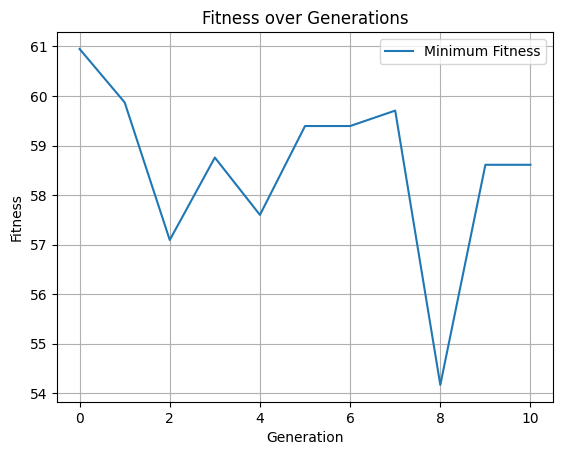

In [15]:
import matplotlib.pyplot as plt

# Assuming 'log' is the logbook from the previous code
gen = log.select("gen")
fit_mins = log.select("min")
fit_avgs = log.select("avg")

plt.plot(gen, fit_mins, label="Minimum Fitness")
#plt.plot(gen, fit_avgs, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend(loc="best")
plt.grid(True)
plt.show()

